# **1. Data Cleaning**

## *Table of Contents*

1. [**Data Cleaning**](./02_Data_Cleaning.ipynb)
   1. [*Library Imports*](#Library-Imports)
   2. [*File Importation*](#File-Importation)
   3. [*Pre-Cleaned Data Inspection*](#Pre-Cleaned-Data-Inspection)
   4. [*Data Preparation / Cleaning for Model Fitting*](#Data-Preparation--Cleaning-for-Model-Fitting)
   5. [*Post-Cleaning Data Inspection*](#Post-Cleaning-Data-Inspection)
   6. [*'BuildingArea' Imputation*](#BuildingArea-Imputation)
   7. [*Post-Analysis of 'BuildingArea' Imputation*](#Post-Analysis-of-'BuildingArea'-Imputation)
   8. [*Export Data*](#Export-Data)
2. [EDA and Feature Engineering](./03_Exploratory_Data_Analysis.ipynb)
3. [Regression Modelling](./04_Regression_Modelling.ipynb)
4. [Time_Series](./05_Time_Series.ipynb)

## **Library Imports**

### Standard library imports

In [1]:
import sys # Provides a way of using operating system dependent functionality
import os  # For interacting with the operating system

### Third-party imports

In [2]:
import matplotlib.pyplot as plt  # For creating visualizations
import missingno as msno  # For visualizing missing data
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import seaborn as sns  # For high-level data visualization

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, SelectKBest, mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score, 
                                     StratifiedKFold, KFold)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

### Local application imports

In [3]:
# Define the absolute path of the parent directory of the script's grandparent directory
# This is useful for module importation from a different directory structure
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(0, parent_dir)

# Local application imports
from utils import plot_utils, func_utils

## **File Importation**

In [4]:
# Determine the absolute path to the directory containing the current script
script_dir = os.path.dirname(os.path.dirname(os.getcwd()))

# Construct the path to the data file
data_path = os.path.join(script_dir, '00_Raw_Data', '0_melb_data.csv')

# Load the dataset, parsing dates to ensure proper datetime format
melb_data = pd.read_csv(data_path, parse_dates=['Date'], dayfirst=True)

C:\Users\AAA\AppData\Local\Temp\ipykernel_33968\1835048994.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  melb_data = pd.read_csv(data_path, parse_dates=['Date'], dayfirst=True)


### Date Extraction

In [5]:
# Data manipulation: extracting year and month from the date for further analysis
melb_data['Year'] = melb_data['Date'].dt.year
melb_data['Month'] = melb_data['Date'].dt.month
melb_data['Date'] = melb_data['Date'].dt.date  # Simplify 'Date' to date format

### Drop Duplicates

In [6]:
# Remove duplicate entries to maintain data integrity
melb_data.drop_duplicates(inplace=True)

## **Pre-Cleaned Data Inspection**

              Rooms         Price      Distance      Postcode      Bedroom2  \
count  13579.000000  1.357900e+04  13579.000000  13579.000000  13579.000000   
mean       2.936151  1.075709e+06     10.137897   3105.296045      2.912365   
std        0.950368  6.393278e+05      5.868924     90.677724      0.959165   
min        1.000000  8.500000e+04      0.000000   3000.000000      0.000000   
25%        2.000000  6.500000e+05      6.100000   3044.000000      2.000000   
50%        3.000000  9.030000e+05      9.200000   3084.000000      3.000000   
75%        3.000000  1.330000e+06     13.000000   3148.000000      3.000000   
max       10.000000  9.000000e+06     48.100000   3977.000000     20.000000   

           Bathroom           Car      Landsize  BuildingArea    YearBuilt  \
count  13579.000000  13517.000000  13579.000000   7126.000000  8205.000000   
mean       1.533029      1.609899    518.087562    143.593649  1964.473248   
std        0.687940      0.962142   1272.523717     83

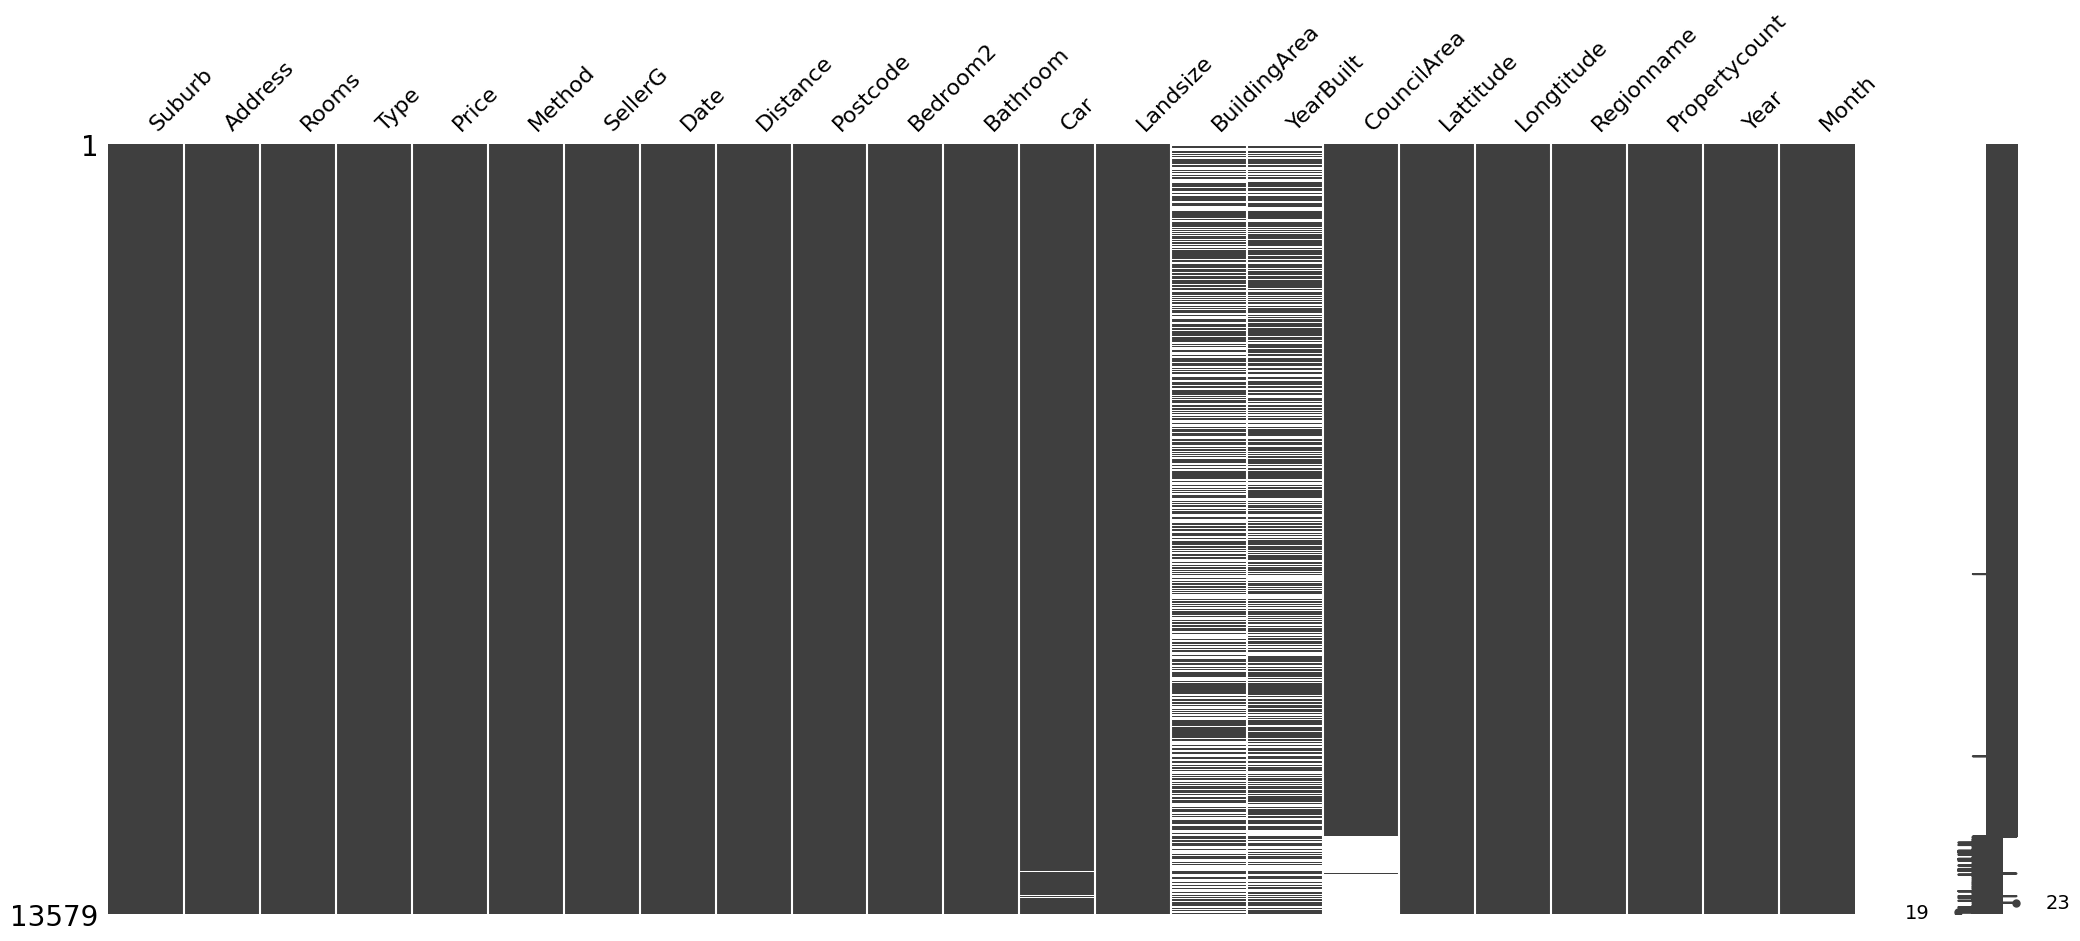

In [7]:
# Display summary statistics for the dataset
print(melb_data.describe())

# Identify missing values across columns
print('\n Missing values across columns:')
print(melb_data.isna().sum())

# Identify number of entries in dataset
print(f'\n Number of entries in dataset: {melb_data.shape[0]}')

# Visualize missing data to guide cleaning and imputation strategies
msno.matrix(melb_data)
plt.show()

## **Data Preparation / Cleaning for Model Fitting**

### Indicator Variable Creation

In [8]:
# Create binary indicators for specific conditions to enhance model interpretation
melb_data['Bathroom_was_0'] = np.where(melb_data['Bathroom'] == 0, True, False)
melb_data['Car_was_missing'] = melb_data['Car'].isna()
melb_data['BuildingArea_was_missing'] = melb_data['BuildingArea'].isna()

###  Resolving Missing Values and Errors

In [9]:
# Replace 0 bathroom counts with the median number of bathrooms.
melb_data['Bathroom'] = np.where(melb_data['Bathroom'] == 0, melb_data['Bathroom'].median(), melb_data['Bathroom'])

# Fill missing values in 'Car' column with the median number of cars.
melb_data.fillna(value={'Car': melb_data['Car'].median()}, inplace=True)

In [10]:
# Define a function to determine the effective number of bedrooms
# based on 'Rooms' and 'Bedroom2' columns
def effective_bedrooms(row):
    """
    Calculate the effective number of bedrooms for a property.
    
    This function takes into account discrepancies between 'Rooms' and 
    'Bedroom2' columns. It applies logic to decide the most representative 
    value for the number of bedrooms.

    Parameters:
    row (pd.Series): A row of the DataFrame.

    Returns:
    int: The calculated effective number of bedrooms.
    """
    if row['Rooms'] > row['Bedroom2'] and row['Bedroom2'] != 0:
        return row['Bedroom2']
    elif row['Rooms'] < row['Bedroom2'] and row['Rooms'] != 0:
        return row['Rooms']
    elif row['Rooms'] == row['Bedroom2']:
        return row['Rooms']
    else:
        return row['Rooms'] + row['Bedroom2']

# Apply the effective_bedrooms function to the dataset
melb_data['Bedroom'] = melb_data.apply(effective_bedrooms, axis=1)

In [11]:
def fill_councilarea(row):
    """
    Fill missing 'CouncilArea' based on properties in the same suburb.

    This function matches properties by 'Suburb', 'Postcode', 'Regionname', 
    and 'Propertycount' to fill missing 'CouncilArea' values. If a matching 
    property with a non-null 'CouncilArea' is found, its 'CouncilArea' value 
    is used.

    Parameters:
    row (pd.Series): A row from the DataFrame.

    Returns:
    str: The filled or original 'CouncilArea' value for the row.
    """
    if pd.isnull(row['CouncilArea']):
        match = melb_data[(row['Suburb'] == melb_data['Suburb']) & 
                          (row['Postcode'] == melb_data['Postcode']) & 
                          (row['Regionname'] == melb_data['Regionname']) & 
                          (row['Propertycount'] == melb_data['Propertycount']) & 
                          pd.notnull(melb_data['CouncilArea'])]
        if not match.empty:
            return match.iloc[0]['CouncilArea']
    return row['CouncilArea']

melb_data['CouncilArea'] = melb_data.apply(fill_councilarea, axis=1)

## **Post-Cleaning Data Inspection**

              Rooms         Price      Distance      Postcode      Bedroom2  \
count  13579.000000  1.357900e+04  13579.000000  13579.000000  13579.000000   
mean       2.936151  1.075709e+06     10.137897   3105.296045      2.912365   
std        0.950368  6.393278e+05      5.868924     90.677724      0.959165   
min        1.000000  8.500000e+04      0.000000   3000.000000      0.000000   
25%        2.000000  6.500000e+05      6.100000   3044.000000      2.000000   
50%        3.000000  9.030000e+05      9.200000   3084.000000      3.000000   
75%        3.000000  1.330000e+06     13.000000   3148.000000      3.000000   
max       10.000000  9.000000e+06     48.100000   3977.000000     20.000000   

           Bathroom           Car      Landsize  BuildingArea    YearBuilt  \
count  13579.000000  13579.000000  13579.000000   7126.000000  8205.000000   
mean       1.535533      1.611680    518.087562    143.593649  1964.473248   
std        0.684165      0.960303   1272.523717     83

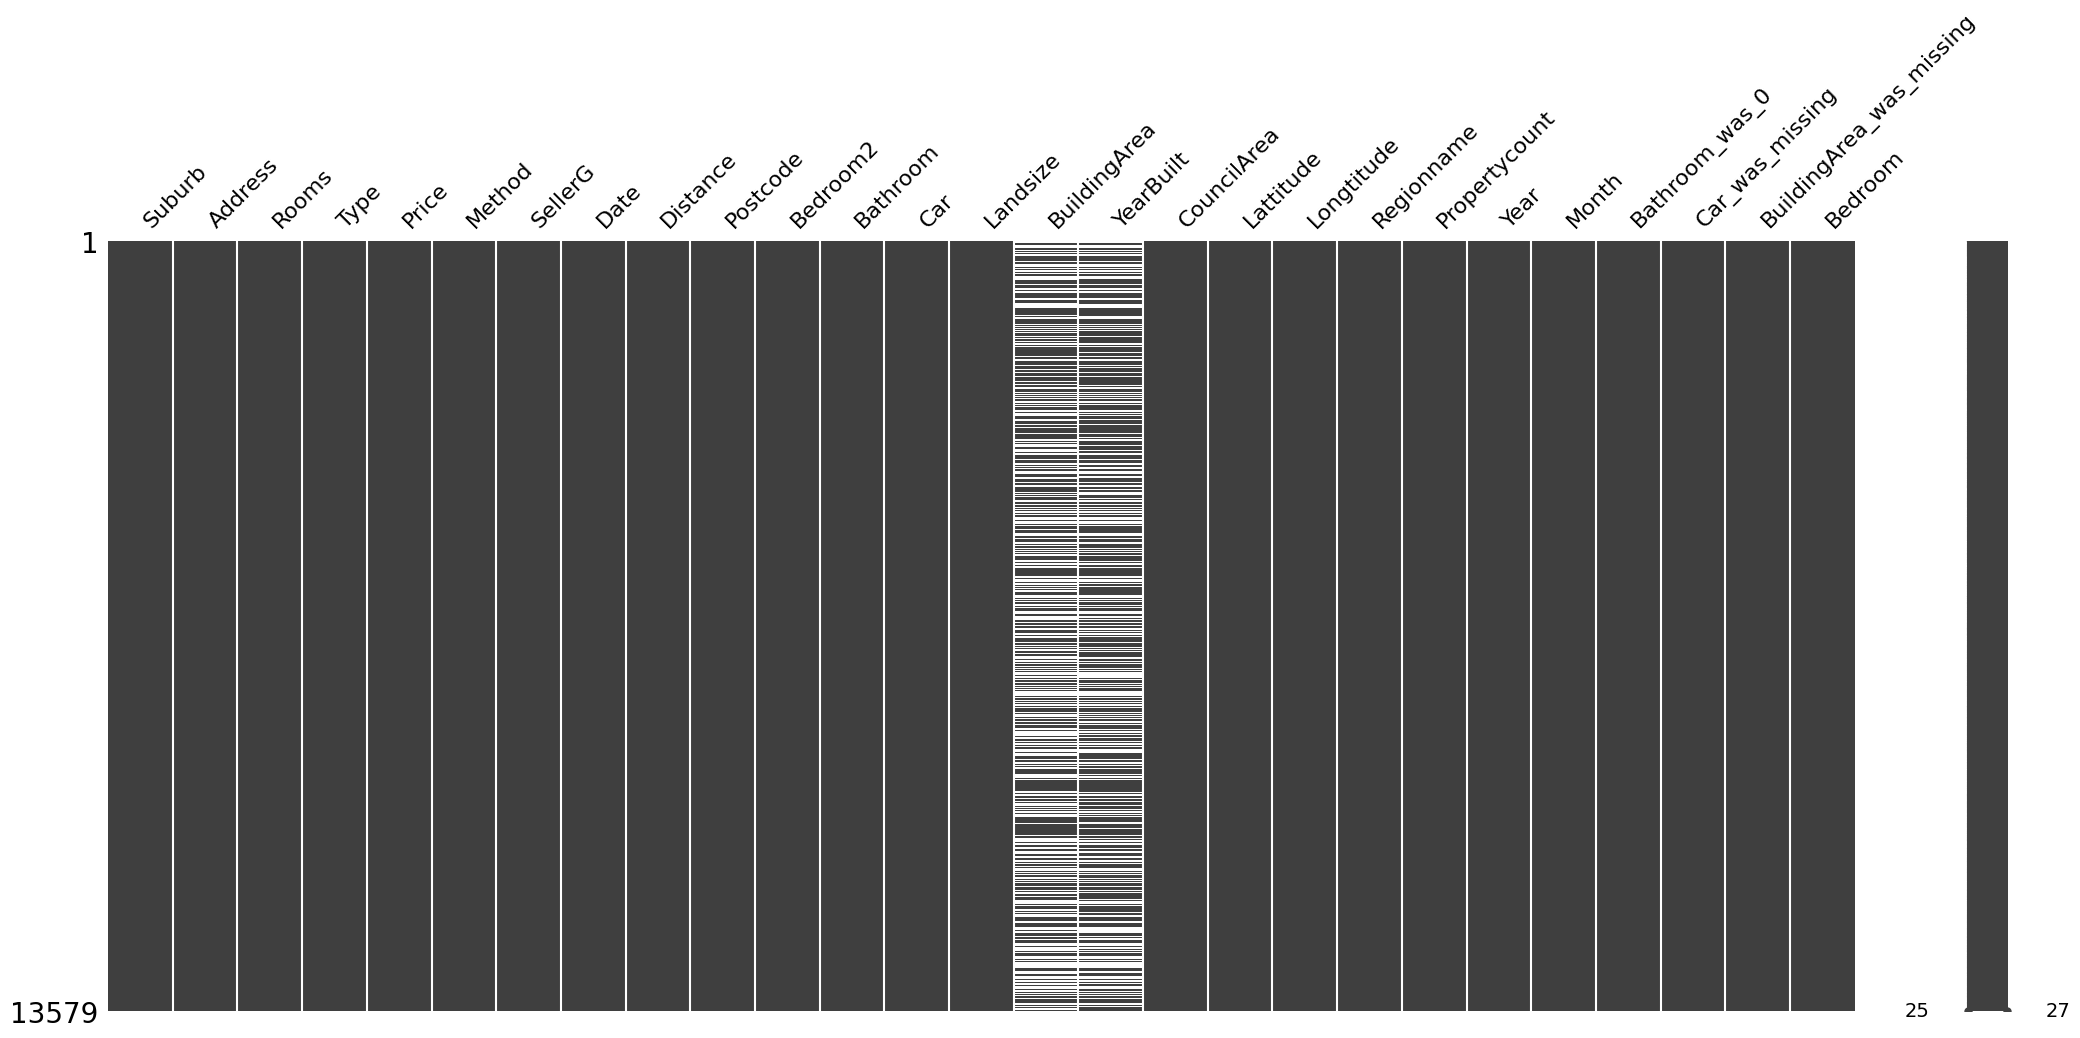

In [12]:
# Summarize the cleaned dataset to verify changes
print(melb_data.describe())

# Check for remaining missing values post-cleaning
print('\n Post-cleaning missing values across columns:')
print(melb_data.isna().sum())

# Visualize the cleaned data to ensure readiness for analysis
msno.matrix(melb_data)
plt.show()

### Handling Outliers

Identify and mitigate outliers in key quantitative columns such as 'Price', 'Bed', 'Bathroom', 'Car', 'Distance', 'Landsize', and 'BuildingArea'.


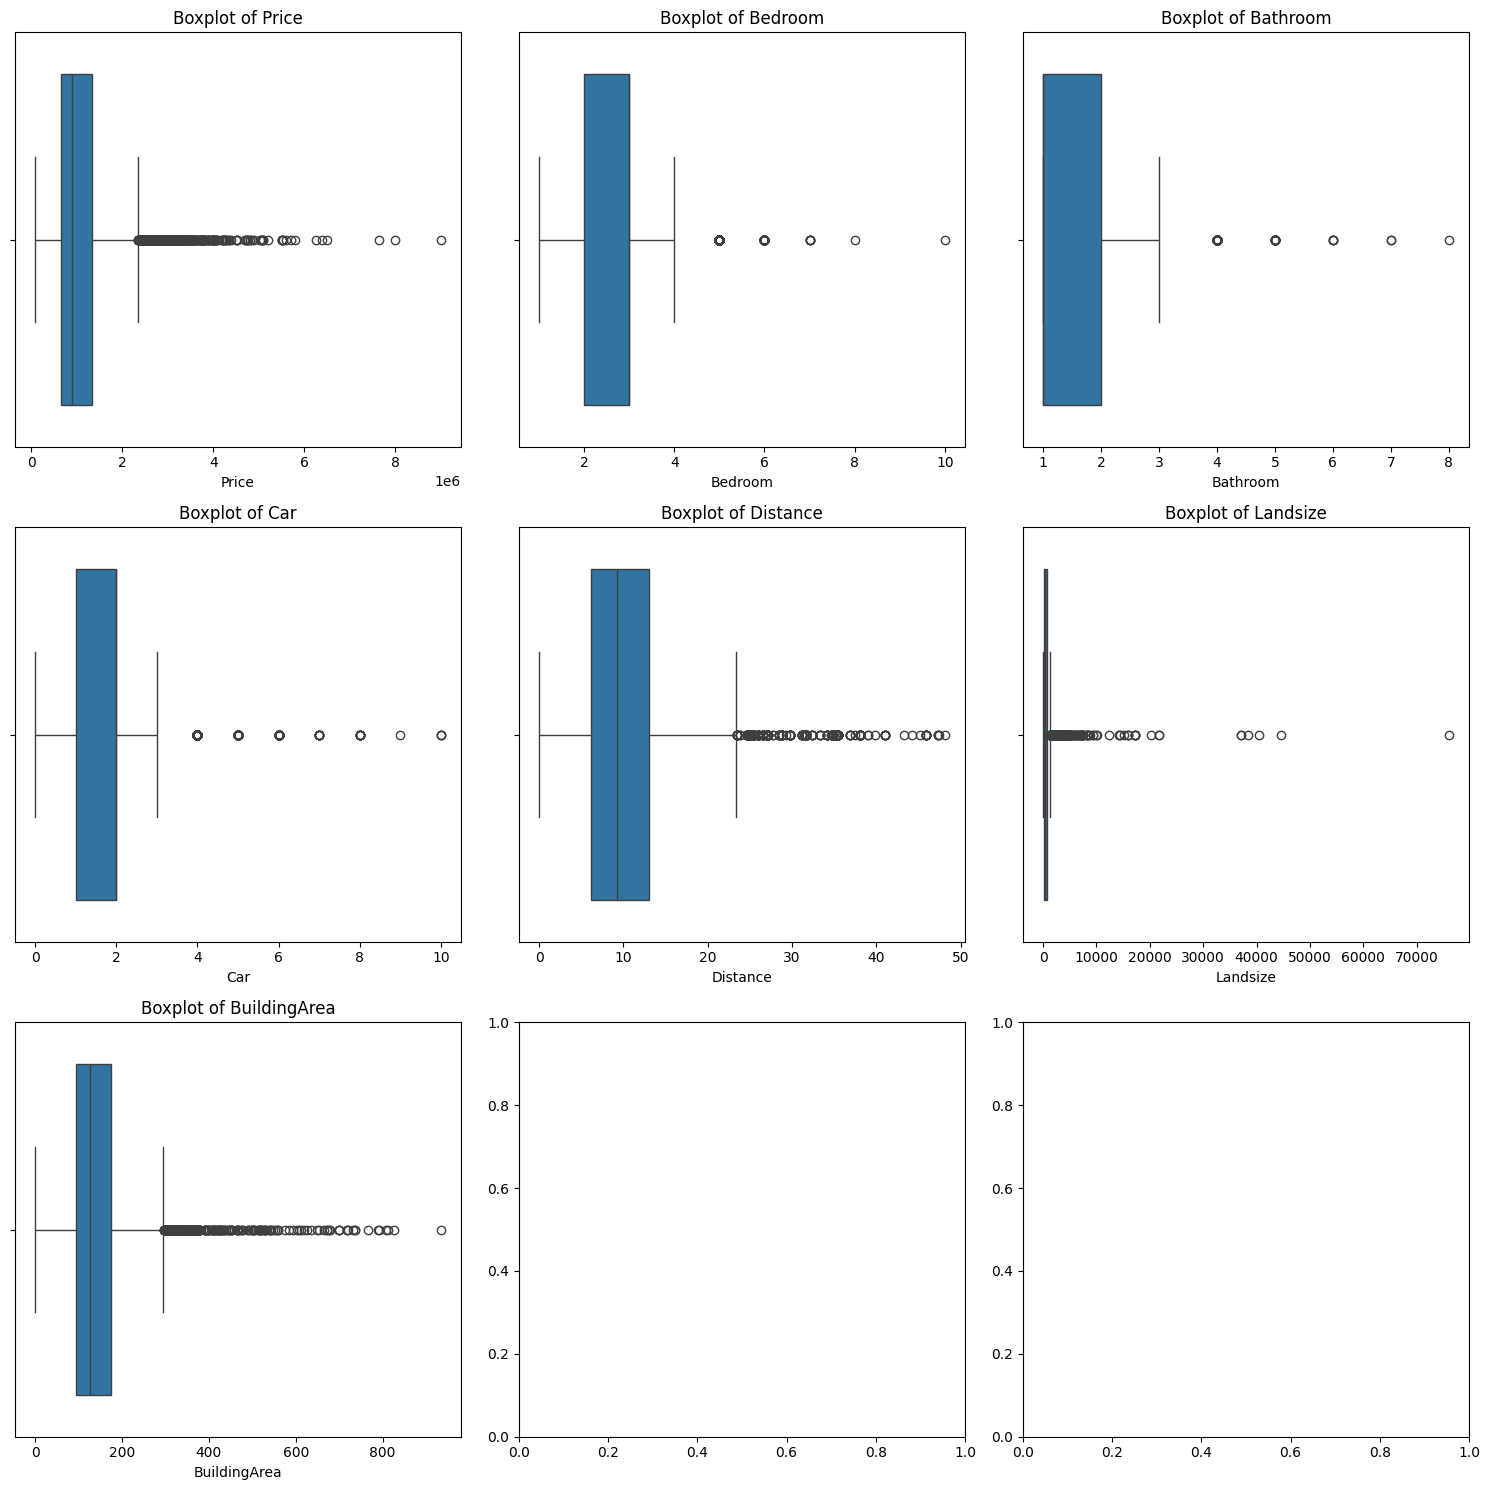

In [13]:
# Define quantitative columns
quant_columns = ['Price', 'Bedroom', 'Bathroom', 'Car', 'Distance', 'Landsize', 'BuildingArea']

# Plot boxplots to visualize outliers
plot_utils.plot_box(data=melb_data, column_list=quant_columns, rows=3, cols=3)

**Note**: Outliers were verified and do match the entries listed in the DataFrame.

#### Fixing Units with Zero Landsize

Units should not have a land size, so we will input zero for these entries as no one looks at the land size of a building for an apartment.

In [14]:
# Set 'Landsize' to 0 for units
melb_data.loc[melb_data['Type'] == 'u', 'Landsize'] = 0

# Create an indicator for imputed land sizes
melb_data['Landsize_Indicator'] = np.where(melb_data['Landsize'] == 0, 1, 0)

#### Handling Entries with Zero Building Area

A building area equal to zero does not make sense. We will impute these entries with our data.

In [15]:
# Impute 0 values in 'BuildingArea' with NaN
melb_data.loc[melb_data['BuildingArea'] == 0, 'BuildingArea'] = np.nan

#### Outlier Removal Using the IQR Method

In [16]:
# Loop through specified columns to handle outliers
for x in ['Price', 'Landsize']:
    # Calculate the first and third quartiles and interquartile range (IQR)
    q1, q3 = melb_data[x].quantile([0.25, 0.75])
    IQR = q3 - q1
    # Define upper and lower bounds for outliers
    upper, lower = q3 + (1.5 * IQR), q1 - (1.5 * IQR)
    # Remove outliers from the dataset
    melb_data = melb_data[melb_data[x].between(lower, upper)].copy()

In [17]:
# Handle outliers for the 'BuildingArea' column
# Calculate quartiles and IQR for 'BuildingArea'
q1, q3 = melb_data['BuildingArea'].quantile([0.25, 0.75])
IQR = q3 - q1
# Define outlier bounds for 'BuildingArea'
upper, lower = q3 + (1.5 * IQR), q1 - (1.5 * IQR)
# Filter out outliers, keeping NaN values
melb_data = melb_data[melb_data['BuildingArea'].isna() | melb_data['BuildingArea'].between(lower, upper)].copy()

### DataFrame Refinement

In [18]:
# Simplify the dataset by dropping columns not needed for further analysis
melb_data.drop(columns=['Rooms', 'Bedroom2', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'], inplace=True)

# Reorder columns for readability and analysis purposes
melb_data = melb_data[[
    'Address', 'Postcode', 'Suburb', 'Regionname', 'CouncilArea', 'Type', 
    'Price', 'SellerG', 'Method', 'Date', 'Year', 'Month', 'Bedroom', 
    'Bathroom', 'Bathroom_was_0', 'Car', 'Car_was_missing', 'Distance',
    'Landsize', 'Landsize_Indicator', 'BuildingArea', 'BuildingArea_was_missing'
]]

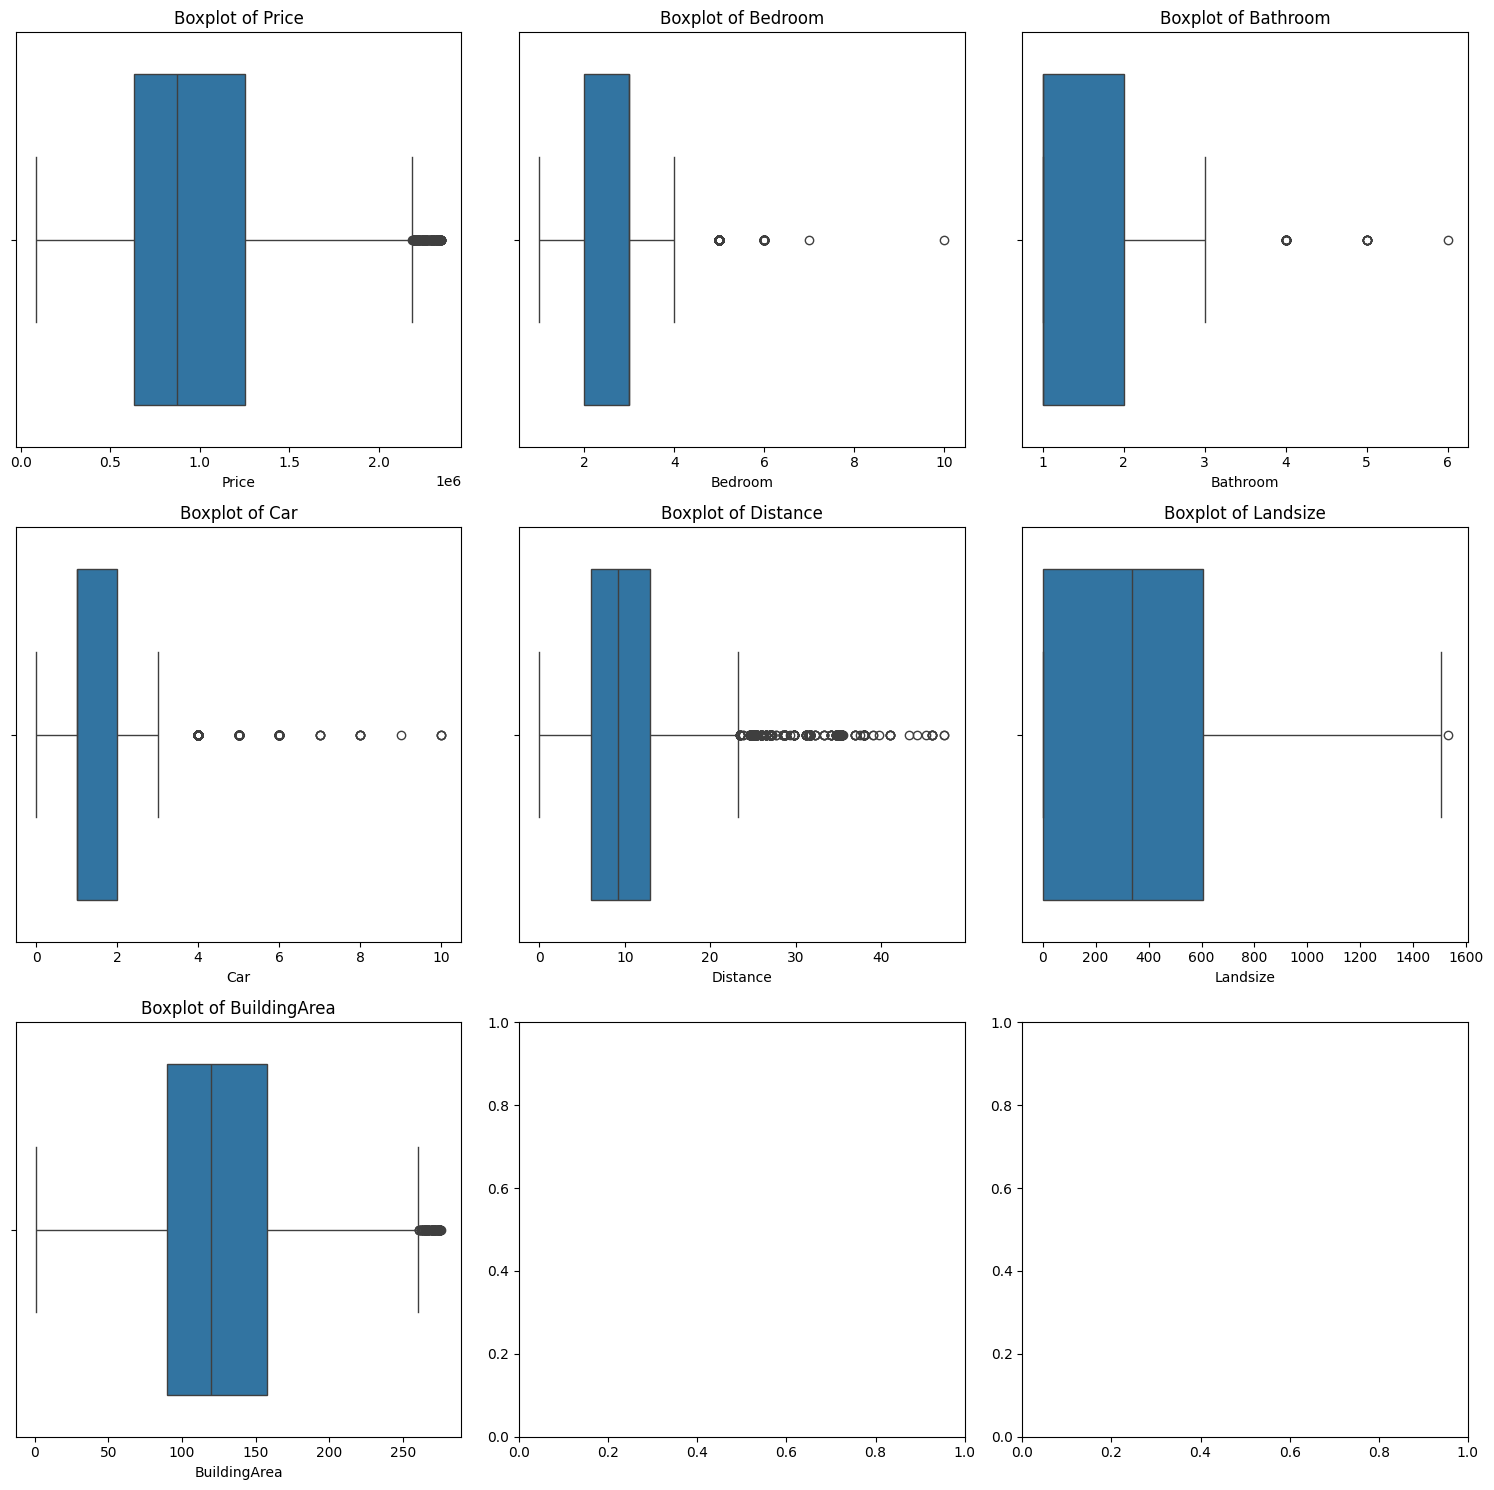

In [19]:
# Plot boxplots to visualize outliers
plot_utils.plot_box(data=melb_data, column_list=quant_columns, rows=3, cols=3)

In [20]:
# Review summary statistics post-outlier removal
print(melb_data.describe())

           Postcode         Price          Year         Month       Bedroom  \
count  12622.000000  1.262200e+04  12622.000000  12622.000000  12622.000000   
mean    3103.112819  9.718174e+05   2016.533513      7.036920      2.819759   
std       89.646530  4.480099e+05      0.498895      2.530705      0.892572   
min     3000.000000  8.500000e+04   2016.000000      1.000000      1.000000   
25%     3044.000000  6.320000e+05   2016.000000      5.000000      2.000000   
50%     3081.000000  8.720000e+05   2017.000000      7.000000      3.000000   
75%     3147.000000  1.253375e+06   2017.000000      9.000000      3.000000   
max     3977.000000  2.350000e+06   2017.000000     12.000000     10.000000   

           Bathroom           Car      Distance      Landsize  \
count  12622.000000  12622.000000  12622.000000  12622.000000   
mean       1.466012      1.566234     10.141705    357.796308   
std        0.606525      0.931967      5.828159    293.242358   
min        1.000000      0.0

## **'BuildingArea' Imputation**

### Preliminary Analysis

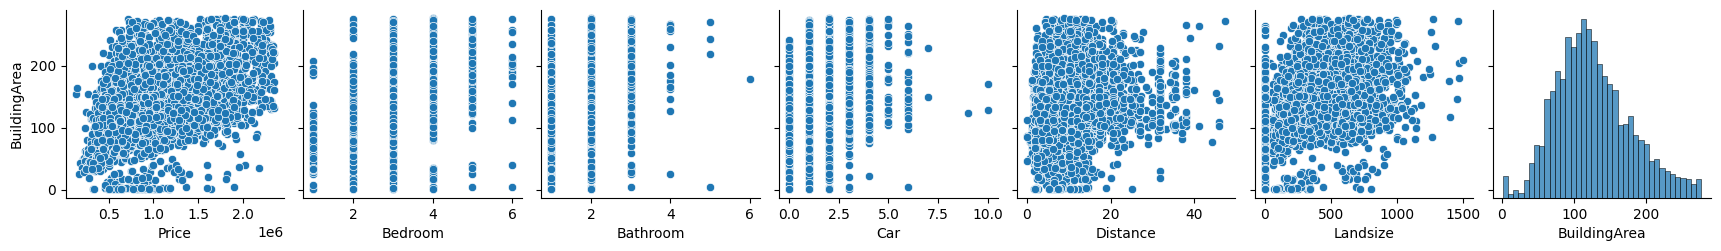

In [21]:
# Explore the relationships between quantitative variables and visualize correlations.
sns.pairplot(data=melb_data[quant_columns], y_vars='BuildingArea')
plt.show()

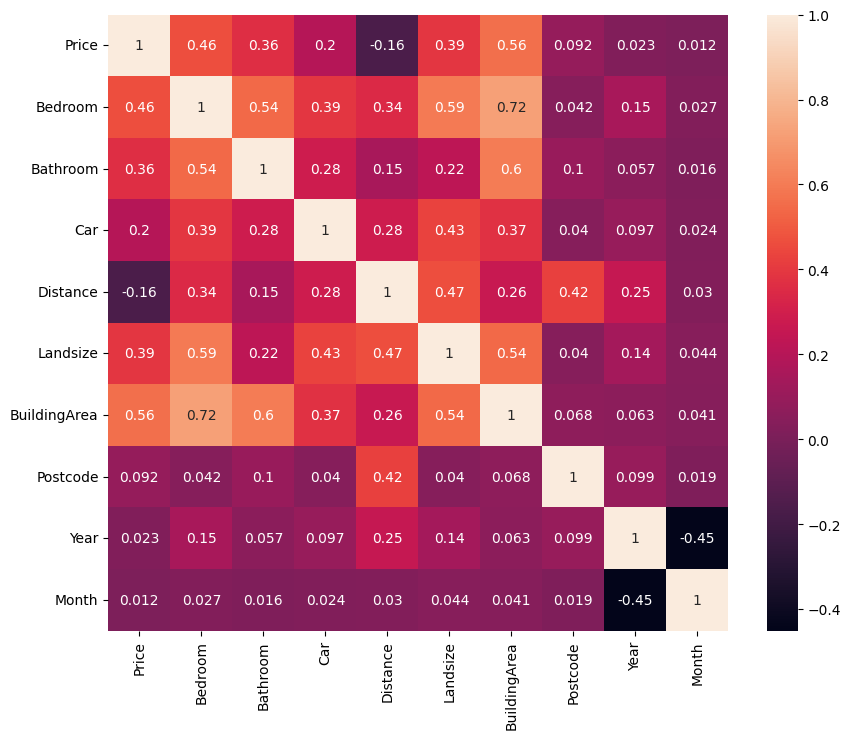

In [22]:
# Extend the list of quantitative columns with additional relevant features
quant_columns_ex = quant_columns + ['Postcode', 'Year', 'Month']

# Calculate the correlation matrix for the specified quantitative columns
corr_test = melb_data[quant_columns_ex].corr()

# Set the size of the figure
plt.figure(figsize=(10, 8))

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_test, annot=True)
plt.show()

### Feature Selection

#### Preparation for Feature Selection

#### Mutual Information (MI)

#### Recursive Feature Elimination (RFE)

**Initialize Your Estimator**:
Choose the model you want to use for feature selection and eventual prediction. Here, I'll use `RandomForestRegressor` as an example.

In [23]:
# Initialize a RandomForestRegressor as the estimator for RFE.
estimator = RandomForestRegressor(n_jobs=-1, random_state=42)


Now, apply `RFECV` to your data. You can specify the cross-validation strategy (e.g., K-fold) and the scoring metric you want to use.

*note*: we switched from `cv_strategy = StratifiedKFold(n_splits=5)` to `cv_strategy = KFold(n_splits=3, shuffle=True, random_state=42)` because `StratifiedKFold` is designed for classification tasks where the target variable is categorical (either binary or multiclass). For regression tasks, you should use `KFold` or another cross-validation generator that does not require the target to be categorical. 

**Review the Results**:
After fitting `RFECV` to your data, you can examine which features were selected and the optimal number of features.

Optimal number of features:  39
Best features:  Index(['Bedroom', 'Bathroom', 'Car', 'Distance', 'Landsize',
       'Northern Metropolitan_Regi', 'Southern Metropolitan_Regi',
       'Western Metropolitan_Regi', 'Darebin_Coun', 'Glen Eira_Coun',
       'Maribyrnong_Coun', 'Monash_Coun', 'Moonee Valley_Coun',
       'Moreland_Coun', 't_Type', 'u_Type', 'Barry_Sell', 'Brad_Sell',
       'Fletchers_Sell', 'Jellis_Sell', 'McGrath_Sell', 'Nelson_Sell',
       'RT_Sell', 'Ray_Sell', 'hockingstuart_Sell', 'S_Meth', 'SP_Meth',
       'VB_Meth', '2017_Year', '3_Mont', '4_Mont', '5_Mont', '6_Mont',
       '7_Mont', '8_Mont', '9_Mont', '10_Mont', '11_Mont', '12_Mont'],
      dtype='object')

In [24]:
top_features = ['Bedroom', 'Bathroom', 'Car', 'Distance', 'Landsize',
       'Northern Metropolitan_Regi', 'Southern Metropolitan_Regi',
       'Western Metropolitan_Regi', 'Darebin_Coun', 'Glen Eira_Coun',
       'Maribyrnong_Coun', 'Monash_Coun', 'Moonee Valley_Coun',
       'Moreland_Coun', 't_Type', 'u_Type', 'Barry_Sell', 'Brad_Sell',
       'Fletchers_Sell', 'Jellis_Sell', 'McGrath_Sell', 'Nelson_Sell',
       'RT_Sell', 'Ray_Sell', 'hockingstuart_Sell', 'S_Meth', 'SP_Meth',
       'VB_Meth', '2017_Year', '3_Mont', '4_Mont', '5_Mont', '6_Mont',
       '7_Mont', '8_Mont', '9_Mont', '10_Mont', '11_Mont', '12_Mont']

**Plot the CV Score vs. Number of Features**:
This helps visualize the performance of the model as you vary the number of features.

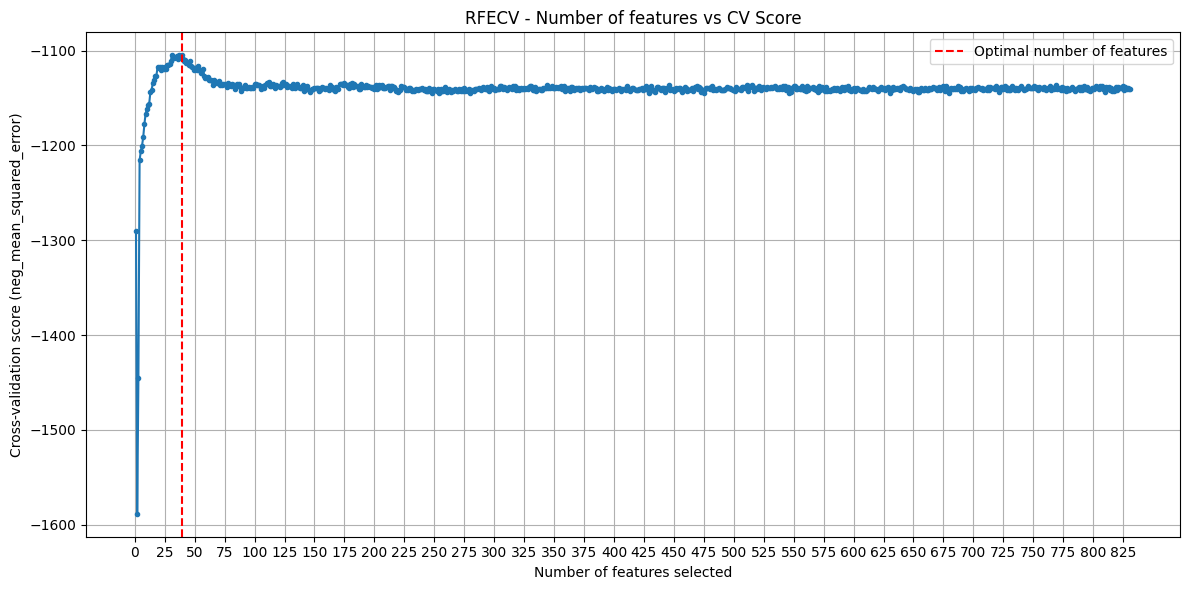

LOOK AT THE GRAPH AND THEN FITTING THE OPTIMAL FEATURES ON THE ACTUAL MODEL AND THEN LOOKING AT THE FEATURE IMPORTANT OF THE MODEL WILL TELL US WHICH TOP N FEATURE (IN OUR CASE LOOKING AT THE GRAPH IS 60) ARE THE MOST IMPORTANT FEATURE TO USE TO PREDICT OUR TARGET

NOTE: WE FIRST OBTAIN THE `predictive_features` FROM FEATURE SELECTION RFE THEN WE FIT THE `predictive_features` ON THE PREDICTIVE RANDOM FOREST MODEL TO SEE OUT OF ALL THE 'OPTIMAL' FEATURES THAT RFECV PICKED WHICH HAVE THE MOST FEATURE RELEVENCE IN COMBANATION OF THE Plot THAT SHOW the CV Score vs. Number of Features WHICH SHOW USE THE MINUMUM # OF FEATURES WE COULD USE FOR THE BEST 'neg_mean_squared_error' SCORE. SO IN TAKING THE MINMUM # OF FEATURE FROM THE PLOT WE TAKE THE TOP N FEATURE THAT IS RELAVENT TO THE MODEL AND THEN WILL REINPUT IT IN THE predictive_features WHICH WILL GIVE US THE OPTIMAL NUMBER OF FEATURES TO USE TO FIT ON TO OUR MODEL TO PREDICT FOR MISSING VALUES OF `BuildingArea`

### Preprocessing for Model Training with Optimized Feature from RFECV

In [25]:
# List of categorical features for dummy variable creation.
categorical_features = [
    'Postcode', 'Suburb', 'Regionname', 'CouncilArea', 'Type', 'SellerG',
    'Method', 'Year', 'Month'
]

# Creating dummy variables for categorical features and converting column names to strings.
melb_predict_data = func_utils.concat_dummies(melb_data, categorical_features)
melb_predict_data.columns = melb_predict_data.columns.astype(str)


# Define predictive features for model training.
predictive_features = top_features
target = 'BuildingArea'

# Drop rows with missing target variable and prepare the feature matrix (X) and target vector (y).
melb_ba_drop = melb_predict_data.dropna(subset=[target])
X = melb_ba_drop[predictive_features]
y = melb_ba_drop[target]

# Split the dataset into training and test sets with a 20% test size and set a random state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

#### GridSearchCV for Random Forest

### Random Forest Model Fitting

In [26]:
'''
# Initialize the RandomForestRegressor with specified hyperparameters.
random_f_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'],
    random_state=42, n_jobs=-1
)
'''

random_f_model = RandomForestRegressor(
    n_estimators=450, max_depth=10, min_samples_split=18,
    random_state=42, n_jobs=-1)

# Fit the model to the training data.
random_f_model.fit(X_train, y_train)

# Predict on training and test data.
y_train_pred = random_f_model.predict(X_train)
y_test_pred = random_f_model.predict(X_test)

### Model Diagnostics

#### Cross Validation

In [27]:
# Perform 5-fold cross-validation to evaluate the model.
cv_scores = cross_val_score(random_f_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores  # Convert scores to positive

# Print cross-validation scores, mean, and standard deviation.
print(f"CV MSE scores: {cv_scores}")
print(f"CV MSE mean: {cv_scores.mean()}")
print(f"CV MSE standard deviation: {cv_scores.std()}")

KeyboardInterrupt: 

#### RMSE Calculation

In [ ]:
# Calculate RMSE for both training and test datasets.
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

### R² (R-squared)

In [ ]:
# R² for training data
r2_train = r2_score(y_train, y_train_pred)

# R² for test data
r2_test = r2_score(y_test, y_test_pred)

print(f"R² for training data: {r2_train}")
print(f"R² for test data: {r2_test}")

#### MSE & MAE Calculation

In [ ]:
# Calculate MSE and MAE for both training and test datasets.
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"\nTraining MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

#### Feature Importance Analysis

In [ ]:
# Assuming `X_train` includes both numerical and processed categorical variables.
feature_names = X_train.columns

# Extract feature importances from the model.
feature_importances = random_f_model.feature_importances_

# Create a Series for the feature importances for easy manipulation and sorting.
importances_series = pd.Series(
    feature_importances, index=feature_names
).sort_values(ascending=False)

print(importances_series)

### Imputing Missing 'BuildingArea' using Predictive Model

In [ ]:
# Predict 'BuildingArea' for rows where it is missing and impute these values.
X_missing = melb_predict_data[melb_predict_data[target].isnull()][predictive_features]
predicted_values = random_f_model.predict(X_missing)
rounded_pv = np.round_(predicted_values, decimals=0)

# Impute the predicted 'BuildingArea' back into the original dataset.
melb_predict_data.loc[melb_predict_data[target].isnull(), target] = rounded_pv

# Extract original dataset columns after imputation to remove dummy variables used for prediction.
# This step restores the dataframe to its initial structure, focusing on key attributes relevant
# for further analysis or reference, following the imputation of 'BuildingArea' using a RandomForest model.
melb_data = melb_predict_data[['Address', 'Postcode', 'Suburb', 'Regionname', 'CouncilArea', 'Type', 
    'Price', 'SellerG', 'Method', 'Date', 'Year', 'Month', 'Bedroom', 
    'Bathroom', 'Bathroom_was_0', 'Car', 'Car_was_missing', 'Distance',
    'Landsize', 'Landsize_Indicator', 'BuildingArea', 'BuildingArea_was_missing']].copy()

## **Post-Analysis of 'BuildingArea' Imputation**

In [ ]:
# Summarize the cleaned dataset to verify changes
print(melb_data.describe())

# Check for remaining missing values post-cleaning
print('\n Post-cleaning missing values across columns:')
print(melb_data.isna().sum())

# Visualize the cleaned data to ensure readiness for analysis
msno.matrix(melb_data)
plt.show()

In [ ]:
# Explore the relationships between quantitative variables and visualize correlations.
sns.pairplot(data=melb_data[quant_columns])
plt.show()

In [ ]:
# Calculate the correlation matrix for the specified quantitative columns
corr_test = melb_data[quant_columns_ex].corr()

# Set the size of the figure
plt.figure(figsize=(10, 8))

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_test, annot=True)
plt.show()

In [ ]:
# Plot boxplots for selected quantitative variables to analyze distribution after 'BuildingArea' imputation.
plot_utils.plot_box(data=melb_data, column_list=quant_columns, rows=3, cols=3)

## **Export Data**

In [ ]:
# Construct the full file path
output_file_path = os.path.join(script_dir, '01_Data_Cleaning', '1_cleaned_melb_data.csv')

# Export the cleaned and processed data to a new CSV file
melb_data.to_csv(output_file_path, index=False)  # Export without the index